In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch

import pandas as pd
import numpy as np

from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, confusion_matrix, classification_report, precision_recall_fscore_support

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
%cd '/content/drive/MyDrive/Credit_card_fraud_detection/'

/content/drive/MyDrive/Credit_card_fraud_detection


In [ ]:
train_df = pd.read_csv('./dataset/train.csv') # Train
val_df = pd.read_csv('./dataset/val.csv') # Validation

In [ ]:
train_df.head()

,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
0,3,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,4.983721,-0.994972
1,4,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,1.418291,-0.994972
2,6,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,-0.256131,-0.994960
3,8,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,0.262698,-0.994901
4,9,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,0.994900,-0.994901


In [ ]:
val_df.head()

,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,V29,V30,Class
0,10,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,-0.255991,-0.994878,0
1,22,0.962496,0.328461,-0.171479,2.109204,1.129566,1.696038,0.107712,0.521502,-1.191311,...,0.402492,-0.048508,-1.371866,0.390814,0.199964,0.016371,-0.014605,0.168937,-0.994784,0
2,63,1.145524,0.575068,0.194008,2.598192,-0.092210,-1.044430,0.531588,-0.241888,-0.896287,...,-0.119703,-0.076510,0.691320,0.633984,0.048741,-0.053192,0.016251,0.169496,-0.994502,0
3,69,0.927060,-0.323684,0.387585,0.544474,0.246787,1.650358,-0.427576,0.615371,0.226278,...,0.079359,0.096632,-0.992569,0.085096,0.377447,0.036096,-0.005960,0.331307,-0.994467,0
4,83,-3.005237,2.600138,1.483691,-2.418473,0.306326,-0.824575,2.065426,-1.829347,4.009259,...,-0.181268,-0.163747,0.515821,0.136318,0.460054,-0.251259,-1.105751,-0.287012,-0.994373,0


In [ ]:
val_normal, val_fraud = val_df['Class'].value_counts()
val_contamination = val_fraud / val_normal
print(f'Validation contamination : [{val_contamination}]')

Validation contamination : [0.0010551491277433877]


In [ ]:
train_x = train_df.drop(columns=['ID']) # Input Data

In [ ]:
# Same ration with Validation dataset -> model parameter : contamination=val_contamination(=0.001055)
model = EllipticEnvelope(support_fraction = 0.994, contamination = val_contamination, random_state = 1004)
model.fit(train_x)

EllipticEnvelope(contamination=0.0010551491277433877, random_state=1004,
                 support_fraction=0.994)

## Optimize parameters
### support_fraction

In [ ]:
val_x = val_df.drop(columns=['ID', 'Class']) # Input Data
val_y = val_df['Class'] # Label

In [ ]:
# Optimize support_fraction hyper paramter for best F1

minRE = 0.99
maxRE = 0.999
    
EpsF1 = []

for TryRE in np.arange(minRE, maxRE, 0.001):
    cov = EllipticEnvelope(support_fraction = TryRE, contamination = val_contamination)
    y_pred = cov.fit_predict(val_x)
    
    y_predLOF = y_pred.copy()
    y_predDF = pd.DataFrame(y_predLOF)
    
    y_predDF[y_predDF[0] == 1] = 0
    y_predDF[y_predDF[0] == -1] = 1
    
    y_predLOF = y_predDF.values
    y_predLOF = np.ravel(y_predLOF)
    
    precision,recall,fbeta_score, support  = precision_recall_fscore_support(val_y, y_predLOF, average='binary')
    
    print("F1 score on test", round(fbeta_score,4), " with support_fraction ", TryRE)
    EpsF1.append([TryRE, round(fbeta_score,4)])

F1 score on test 0.6557  with support_fraction  0.99
F1 score on test 0.6557  with support_fraction  0.991
F1 score on test 0.6557  with support_fraction  0.992
F1 score on test 0.6557  with support_fraction  0.993
F1 score on test 0.8197  with support_fraction  0.994
F1 score on test 0.8197  with support_fraction  0.995
F1 score on test 0.8197  with support_fraction  0.996
F1 score on test 0.8197  with support_fraction  0.997
F1 score on test 0.8197  with support_fraction  0.998
F1 score on test 0.8197  with support_fraction  0.999


In [ ]:
EpsF1df = pd.DataFrame(EpsF1, columns = ['SupFrac', 'F1'])
EpsF1df.head()

,SupFrac,F1
0,0.990,0.6557
1,0.991,0.6557
2,0.992,0.6557
3,0.993,0.6557
4,0.994,0.8197


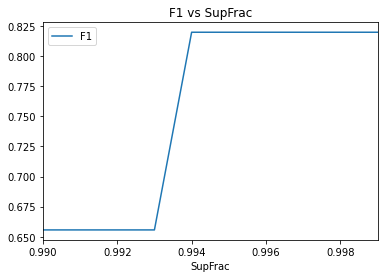

In [ ]:
EpsF1df.plot.line("SupFrac","F1")
plt.xlim(minRE, maxRE)
plt.title("F1 vs SupFrac")
plt.show()

### contamination

In [ ]:
minCT = 0.0008
maxCT = 0.0012
np.arange(minCT, maxCT, 0.00002)

array([0.0008 , 0.00082, 0.00084, 0.00086, 0.00088, 0.0009 , 0.00092,
       0.00094, 0.00096, 0.00098, 0.001  , 0.00102, 0.00104, 0.00106,
       0.00108, 0.0011 , 0.00112, 0.00114, 0.00116, 0.00118])

In [ ]:
# Optimize contamination hyper paramter for best F1

minCT = 0.0008
maxCT = 0.0012
    
CTF1 = []

for TryCT in np.arange(minCT, maxCT, 0.00002):
    cov = EllipticEnvelope(support_fraction = 0.995, contamination = TryCT)
    y_pred = cov.fit_predict(val_x)
    
    y_predLOF = y_pred.copy()
    y_predDF = pd.DataFrame(y_predLOF)
    
    y_predDF[y_predDF[0] == 1] = 0
    y_predDF[y_predDF[0] == -1] = 1
    
    y_predLOF = y_predDF.values
    y_predLOF = np.ravel(y_predLOF)
    
    precision,recall,fbeta_score, support  = precision_recall_fscore_support(val_y, y_predLOF, average='binary')
    
    print("F1 score on test", round(fbeta_score,4), " with contamination ", TryCT)
    CTF1.append([TryCT, round(fbeta_score,4)])

F1 score on test 0.7547  with contamination  0.0008
F1 score on test 0.7407  with contamination  0.0008200000000000001
F1 score on test 0.7407  with contamination  0.0008400000000000001
F1 score on test 0.7636  with contamination  0.0008600000000000002
F1 score on test 0.7857  with contamination  0.0008800000000000002
F1 score on test 0.7857  with contamination  0.0009000000000000003
F1 score on test 0.807  with contamination  0.0009200000000000004
F1 score on test 0.807  with contamination  0.0009400000000000004
F1 score on test 0.8276  with contamination  0.0009600000000000005
F1 score on test 0.8276  with contamination  0.0009800000000000004
F1 score on test 0.8475  with contamination  0.0010000000000000005
F1 score on test 0.8333  with contamination  0.0010200000000000005
F1 score on test 0.8333  with contamination  0.0010400000000000006
F1 score on test 0.8197  with contamination  0.0010600000000000006
F1 score on test 0.8197  with contamination  0.0010800000000000007
F1 score on 

In [ ]:
CTF1df = pd.DataFrame(CTF1, columns = ['SupFrac', 'F1'])
CTF1df.head()

,SupFrac,F1
0,0.00080,0.7547
1,0.00082,0.7407
2,0.00084,0.7407
3,0.00086,0.7636
4,0.00088,0.7857


In [ ]:
final_model = EllipticEnvelope(support_fraction = 0.995, contamination = 0.001, random_state = 1004)
final_model.fit(train_x)

EllipticEnvelope(contamination=0.001, random_state=1004, support_fraction=0.995)

In [ ]:
test_df = pd.read_csv('./dataset/test.csv') # Train
test_df.head()

,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
0,AAAA0x1,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,1.783274,-0.994983
1,AAAA0x2,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.269825,-0.994983
2,AAAA0x5,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0.670579,-0.994960
3,AAAA0x7,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,-0.237686,-0.994937
4,AAAA0xc,0.384978,0.616109,-0.874300,-0.094019,2.924584,3.317027,0.470455,0.538247,-0.558895,...,0.049924,0.238422,0.009130,0.996710,-0.767315,-0.492208,0.042472,-0.054337,-0.167819,-0.994866


In [ ]:
test_x = test_df.drop(columns=['ID'])

In [ ]:
def get_pred_label(model, x, k):
  prob = model.score_samples(x)
  prob = torch.tensor(prob, dtype = torch.float)
  topk_indices = torch.topk(prob, k = k, largest = False).indices

  pred = torch.zeros(len(x), dtype = torch.long)
  pred[topk_indices] = 1
  return pred.tolist(), prob.tolist()

In [ ]:
test_pred, _ = get_pred_label(final_model, test_x, 318)
print('n_fraud : ', sum(test_pred))

n_fraud :  318


In [ ]:
submit = pd.read_csv('./dataset/sample_submission.csv')
submit.head()

,ID,Class
0,AAAA0x1,1
1,AAAA0x2,1
2,AAAA0x5,1
3,AAAA0x7,1
4,AAAA0xc,1


In [ ]:
submit['Class'] = test_pred
submit.to_csv('ee3.csv', index=False)

In [ ]:
pd.read_csv('ee3.csv')['Class'].sum()

318